# New Data Labeled Analytics

This notebook loads `data/results/new_data_labeled.csv` (the output of our anomaly‐detection pipeline) and performs basic analytics on the newly labeled data:  
1. Previewing the data  
2. Descriptive statistics of sensor readings  
3. Counting anomalies per feature  
4. Visualizing anomaly rates  
5. Time‐based summaries (e.g., hourly anomaly counts)

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Define the path to the labeled CSV
notebook_dir = Path().resolve()
labeled_path = notebook_dir / ".." / "data" / "results" / "new_data_labeled.csv"

# Verify that the file exists
if not labeled_path.exists():
    raise FileNotFoundError(f"{labeled_path} not found.")

In [38]:
# Load the labeled DataFrame
df = pd.read_csv(labeled_path, parse_dates=["timestamp"])

# Show first few rows and column info
display(df.head())
df.info()

,timestamp,temp_C,humidity_%,accel_x,accel_y,accel_z,time_str,raw_anomaly_temp_C,label_temp_C,raw_anomaly_humidity_%,label_humidity_%,raw_anomaly_accel_x,label_accel_x,raw_anomaly_accel_y,label_accel_y,raw_anomaly_accel_z,label_accel_z,anomaly_features
0,2025-06-03 23:14:56.443629-04:00,21.46,65.56,0.062622,-0.075073,1.016235,11:14:56 PM,1,normal,-1,anomaly,1,normal,1,normal,1,normal,humidity_%
1,2025-06-03 23:14:57.787117-04:00,21.46,65.61,0.075928,-0.105347,0.999390,11:14:57 PM,1,normal,-1,anomaly,1,normal,1,normal,1,normal,humidity_%
2,2025-06-03 23:14:59.105153-04:00,21.46,65.66,0.070435,-0.096680,0.999512,11:14:59 PM,1,normal,-1,anomaly,1,normal,1,normal,1,normal,humidity_%
3,2025-06-03 23:15:00.471945-04:00,21.46,65.70,-0.093262,-0.418579,-0.931030,11:15:00 PM,1,normal,-1,anomaly,1,normal,1,normal,-1,anomaly,"humidity_%,accel_z"
4,2025-06-03 23:15:01.866098-04:00,21.47,65.77,-0.477417,-0.808472,-0.349487,11:15:01 PM,1,normal,-1,anomaly,-1,anomaly,-1,anomaly,-1,anomaly,"humidity_%,accel_x,accel_y,accel_z"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype                    
---  ------                  --------------  -----                    
 0   timestamp               8 non-null      datetime64[ns, UTC-04:00]
 1   temp_C                  8 non-null      float64                  
 2   humidity_%              8 non-null      float64                  
 3   accel_x                 8 non-null      float64                  
 4   accel_y                 8 non-null      float64                  
 5   accel_z                 8 non-null      float64                  
 6   time_str                8 non-null      object                   
 7   raw_anomaly_temp_C      8 non-null      int64                    
 8   label_temp_C            8 non-null      object                   
 9   raw_anomaly_humidity_%  8 non-null      int64                    
 10  label_humidity_%        8 non-null      ob

In [39]:
# Select only the numeric sensor columns for statistics
numeric_cols = ["temp_C", "humidity_%", "accel_x", "accel_y", "accel_z"]

# Display descriptive stats
desc_stats = df[numeric_cols].describe().T
desc_stats

,count,mean,std,min,25%,50%,75%,max
temp_C,8.0,21.463750,0.005175,21.460000,21.460000,21.460000,21.470000,21.470000
humidity_%,8.0,65.786250,0.198993,65.560000,65.647500,65.735000,65.900000,66.150000
accel_x,8.0,-0.091690,0.297288,-0.477417,-0.354431,-0.015320,0.071808,0.382324
accel_y,8.0,-0.360794,0.414025,-0.989990,-0.653564,-0.261963,-0.091278,0.209717
accel_z,8.0,0.455780,0.762895,-0.931030,-0.024933,0.887817,1.003693,1.052124


In [40]:
# List of features to examine
features = ["temp_C", "humidity_%", "accel_x", "accel_y", "accel_z"]

# Build a table of normal vs. anomaly counts
anomaly_counts = {}
for feat in features:
    label_col = f"label_{feat}"
    counts = df[label_col].value_counts()
    anomaly_counts[feat] = {
        "normal": int(counts.get("normal", 0)),
        "anomaly": int(counts.get("anomaly", 0))
    }

counts_df = pd.DataFrame(anomaly_counts).T
counts_df["percent_anomaly"] = (
    counts_df["anomaly"] / (counts_df.sum(axis=1)) * 100
).round(2)

counts_df

,normal,anomaly,percent_anomaly
temp_C,8,0,0.0
humidity_%,0,8,100.0
accel_x,5,3,37.5
accel_y,5,3,37.5
accel_z,4,4,50.0


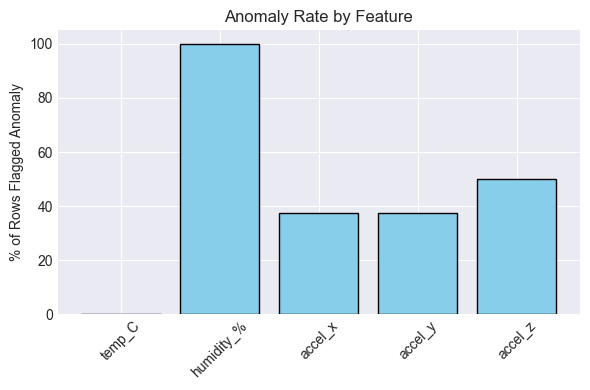

In [41]:
plt.figure(figsize=(6, 4))
plt.bar(
    counts_df.index,
    counts_df["percent_anomaly"],
    color="skyblue",
    edgecolor="black"
)
plt.ylabel("% of Rows Flagged Anomaly")
plt.title("Anomaly Rate by Feature")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [42]:
# Create a boolean column: True if any feature was flagged
df["any_anomaly"] = df.apply(
    lambda row: any(row[f"label_{feat}"] == "anomaly" for feat in features),
    axis=1
)

summary = {
    "all_normal": int((df["any_anomaly"] == False).sum()),
    "at_least_one_anomaly": int((df["any_anomaly"] == True).sum())
}
pd.DataFrame.from_dict(summary, orient="index", columns=["count"])


,count
all_normal,0
at_least_one_anomaly,8


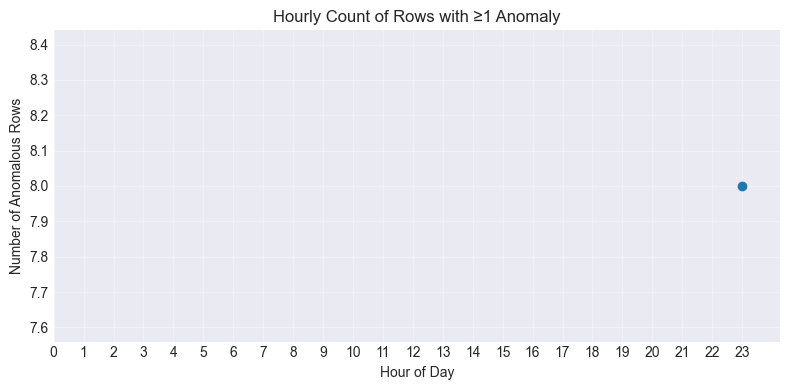

,hour,anomaly_count
0,23,8


In [43]:
# Ensure timestamp is timezone‐aware or naive datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Extract hour
df["hour"] = df["timestamp"].dt.hour

# Count how many anomaly rows occur in each hour
hourly_anomaly_counts = df[df["any_anomaly"]].groupby("hour").size().rename("anomaly_count").reset_index()

plt.figure(figsize=(8, 4))
plt.plot(hourly_anomaly_counts["hour"], hourly_anomaly_counts["anomaly_count"], marker="o", linestyle="-")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Anomalous Rows")
plt.title("Hourly Count of Rows with ≥1 Anomaly")
plt.xticks(range(0, 24))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

hourly_anomaly_counts


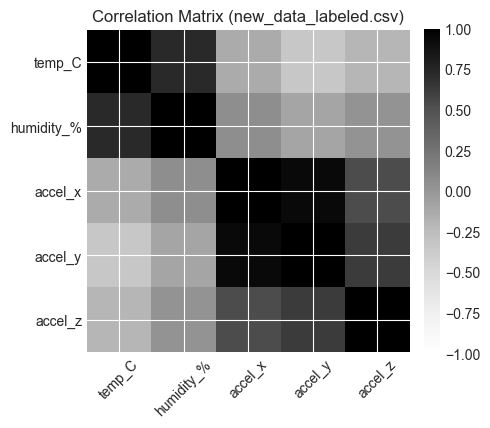

,temp_C,humidity_%,accel_x,accel_y,accel_z
temp_C,1.00,0.72,-0.14,-0.34,-0.21
humidity_%,0.72,1.00,0.05,-0.10,0.02
accel_x,-0.14,0.05,1.00,0.93,0.53
accel_y,-0.34,-0.10,0.93,1.00,0.62
accel_z,-0.21,0.02,0.53,0.62,1.00


In [44]:
# Compute Pearson correlation on the numeric sensor columns
corr_matrix = df[numeric_cols].corr().round(2)

plt.figure(figsize=(5, 5))
plt.imshow(corr_matrix, vmin=-1, vmax=1)
plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title("Correlation Matrix (new_data_labeled.csv)")
plt.tight_layout()
plt.show()

corr_matrix


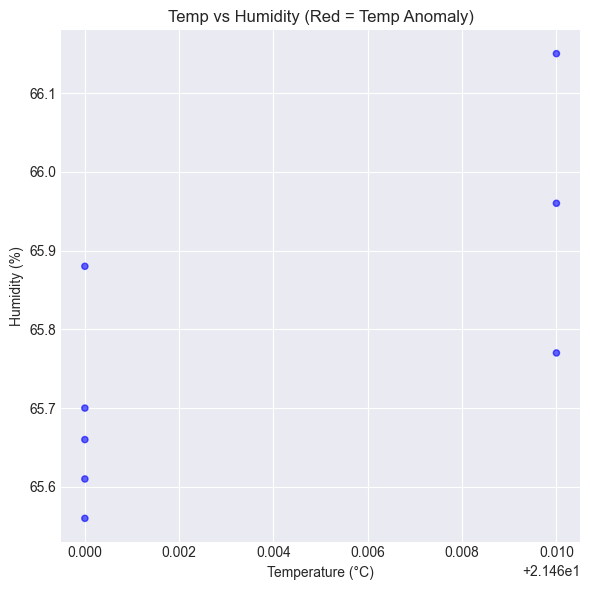

In [45]:
# Example: scatter of temp_C vs. humidity_% colored by anomaly
colors = df["label_temp_C"].map({"normal": "blue", "anomaly": "red"})
plt.figure(figsize=(6, 6))
plt.scatter(df["temp_C"], df["humidity_%"], c=colors, alpha=0.6, s=20)
plt.xlabel("Temperature (°C)")
plt.ylabel("Humidity (%)")
plt.title("Temp vs Humidity (Red = Temp Anomaly)")
plt.tight_layout()
plt.show()
